In [1]:
import torch
import numpy as np
from sbi.inference import prepare_for_sbi, SNLE, SNPE
from sbi.simulators.linear_gaussian import diagonal_linear_gaussian
import sbi.utils as sbi_utils

### Load theta and x

In [2]:
data = np.load('../../../arco_sims/small_prior/hay_objectives/hay.npz', allow_pickle=True)

x = torch.as_tensor(data['data'], dtype=torch.float32)
theta = torch.as_tensor(data['params'], dtype=torch.float32)

In [3]:
import sys
sys.path.append('../')

In [4]:
from parameter_setup import load_ground_truth_params, load_prior_min, load_prior_max

### Load data to standardize - not strictly needed, SNPE should take care of this.

In [5]:
x_mean = x.mean(dim=0)
x_std = x.std(dim=0)

dummy_prior = sbi_utils.BoxUniform(torch.as_tensor(load_prior_min()), torch.as_tensor(load_prior_max()))

theta_mean = theta.mean(dim=0)
theta_std = theta.std(dim=0)

In [6]:
x = (x-x_mean) / x_std
theta = (theta-theta_mean) / theta_std

### Create dummy simulator and dummy prior

In [9]:
def dummy_simulator(theta):
    return torch.ones(1,11)

dummy_prior = sbi_utils.BoxUniform(torch.as_tensor(load_prior_min()), torch.as_tensor(load_prior_max()))
_bound = torch.sqrt(torch.as_tensor(3.))
dummy_prior_norm = sbi_utils.BoxUniform(-_bound*torch.ones(35), _bound*torch.ones(35))

In [10]:
from sbi.utils.get_nn_models import posterior_nn

In [13]:
simulator, prior = prepare_for_sbi(dummy_simulator, dummy_prior_norm)

density_estimator_build_fun = posterior_nn(model='nsf', hidden_features=60, num_transforms=5)

In [16]:
inference = SNPE(
    simulator, 
    prior,
    density_estimator=density_estimator_build_fun
)

In [19]:
inference.provide_presimulated(theta[:1000], x[:1000]), # todo: remove the [:1000] to train on all datasamples)

(None,)

In [23]:
posterior = inference(
    num_simulations=0, # we want to run 0 'additional' simulations, i.e. use only presimulated data.
    stop_after_epochs=5, # default is 20
)

/home/michael/anaconda3/envs/sbi/lib/python3.8/site-packages/nflows/transforms/standard.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "_shift", torch.tensor(shift if (shift is not None) else 0.0)
/home/michael/anaconda3/envs/sbi/lib/python3.8/site-packages/nflows/transforms/standard.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "_scale", torch.tensor(scale if (scale is not None) else 1.0)


Neural network successfully converged after 39 epochs.


In [ ]:
import pickle
with open('../results/posteriors/200723_posterior_SNPE_small_prior.pickle', 'wb') as handle:
    pickle.dump(posterior, handle)

# Temper the posterior

In [65]:
import numpy as np
x_o = torch.as_tensor(np.load('../results/observation/x_o_hay.npz')['x_o'], dtype=torch.float32)

In [66]:
x_o = (x_o - x_mean) / x_std
x_o = x_o.unsqueeze(0)

In [67]:
x_o

tensor([[-0.5644, -1.3513, -1.3530, -1.3484, -0.5069, -0.5728, -1.3571, -0.5032,
         -0.5261, -1.2379, -1.3531]])

### Analyse posterior

In [68]:
import pickle
with open('../results/posteriors/200723_posterior_SNPE_small_prior.pickle', 'rb') as handle:
    posterior = pickle.load(handle)

In [69]:
s = []
num_iter = 5
num_samples_per_iter = 1000

for k in range(num_iter):
    print("new iter,", k)
    samples = posterior.sample((num_samples_per_iter,), x=x_o).detach()

    # denormalize the samples
    samples = samples * theta_std + theta_mean

    # convert to list for pickling
    samples_list = samples.numpy().tolist()
    
    s.append(samples_list)
s = np.asarray(s)
s = s.reshape(num_iter*num_samples_per_iter, -1)

new iter, 0
new iter, 1
new iter, 2
new iter, 3
new iter, 4


In [70]:
s_list = s.tolist()

In [71]:
print(s_list[0])

[132.32936096191406, 0.0014270739629864693, 156.19456481933594, 0.0018764191772788763, 183.21475219726562, 0.00888088159263134, 0.0010408746311441064, 0.0008210628875531256, 9.451342339161783e-05, -5.537644028663635e-06, 0.0036116025876253843, 5.055480869486928e-07, -1.369426172459498e-08, 0.03448036313056946, 0.07948364317417145, 0.04899311065673828, 0.09553893655538559, 0.01463534776121378, 3.7601919174194336, 3.825876235961914, 0.010000682435929775, 0.006306581664830446, 0.0013216231018304825, 0.0172172449529171, 0.06220752373337746, 0.0009960567113012075, 0.053174763917922974, -2.933182954788208, 1.9999974966049194, 1.2448804378509521, 4.333119431976229e-05, 2.1130126697244123e-05, 4.237393295625225e-05, 2.264529757667333e-05, 1.626866340637207]


In [72]:
with open('../results/samples/200723_posteriorSNPE_small_prior_samples.pickle', 'wb') as handle:
    pickle.dump(s_list, handle, protocol=2)

In [73]:
gt_params = [137.862136034238,
 0.0005793520824526776,
 199.1298048149789,
 0.0006108049075983062,
 152.1647419393015,
 0.00742430653684668,
 0.0010965218089651857,
 0.0008186770602065786,
 0.00011435310571497434,
 0.0022763084379226854,
 0.0036986082079423594,
 0.00013883334761566004,
 3.2474860530531394e-06,
 0.005426837416265438,
 0.10568666421909532,
 0.04812676692103998,
 0.094826660872338,
 0.013854989311151315,
 3.9010342040060975,
 3.8851157748263354,
 0.009964343408409574,
 0.006000497448875096,
 0.0012602755616811401,
 0.01392240648099882,
 0.06283710421562513,
 6.68382138396179e-05,
 0.08311048073340864,
 -2.9836949894223825,
 1.9642986130169147,
 1.2999358521956366,
 4.4931548434199036e-05,
 2.062212836678345e-05,
 4.22059843297412e-05,
 2.2409802171891654e-05,
 1.7109080877160283]

In [74]:
gt_params_norm = (torch.as_tensor(gt_params) - theta_mean) / theta_std

In [75]:
theta_std

tensor([5.1931e+00, 8.2940e-04, 2.8278e+01, 8.4140e-04, 2.8299e+01, 1.4291e-03,
        1.4438e-04, 2.8858e-05, 2.8863e-05, 4.0768e-03, 2.8861e-04, 2.1269e-04,
        1.7392e-05, 1.8220e-02, 2.8848e-02, 2.8863e-03, 2.8855e-03, 1.1553e-03,
        9.8906e-02, 1.0324e-01, 1.7506e-04, 2.8868e-04, 2.8877e-04, 2.8874e-03,
        2.8886e-03, 6.7118e-04, 2.8859e-02, 5.4655e-02, 4.5230e-02, 5.7764e-02,
        2.0207e-06, 7.0613e-07, 2.0211e-06, 8.7255e-07, 7.7020e-02])

In [76]:
gt_params_norm

tensor([ 5.3259e-02, -6.9323e-01,  1.1602e-04, -6.6423e-01,  6.4326e-04,
         1.1268e-03,  7.8452e-04, -9.0223e-02,  7.7440e-04, -3.6456e-01,
        -5.6374e-03, -3.0653e-01, -6.2839e-01, -5.4545e-01, -3.3278e-03,
        -5.0302e-02,  5.3150e-02,  3.2238e-03, -1.1837e-01, -1.2263e-01,
         1.0539e+00, -6.0007e-03,  2.0572e-03, -1.4870e-03, -2.5277e-02,
        -6.9635e-01,  3.8597e-04, -2.1351e-01, -1.0882e-01,  3.4188e-02,
        -2.1713e-02,  1.2705e-02, -8.5841e-03, -7.0671e-02,  1.8677e-02])

In [77]:
samples = posterior.sample((2000,), x=x_o).detach()

In [78]:
probs = posterior.log_prob(samples, x=x_o).detach().numpy()
prob_of_gt = posterior.log_prob(gt_params_norm.unsqueeze(0), x=x_o).detach().numpy()

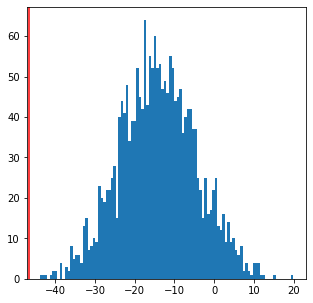

In [79]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(5,5))
_ = plt.hist(probs, bins=100)
ax.axvline(prob_of_gt, color='r')

### Posterior predictives
Has to be done in a different virtual env with python 2.